In [208]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.signal import savgol_filter
%matplotlib inline

In [209]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [210]:
disp_figs = True

In [257]:
M = 1 # Number of Spiking motifs
N = 10 # Number of input neurons
D = 31 # temporal depth of receptive field
T = 1000
dt = 1
nrn_fr = 40 # hz
pg_fr = 6 # hz
background_noise_fr = 10 # h

np.random.seed(41)

In [258]:
# for matplotlib
colors = np.array(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
len(colors)

10

# Generate the PG Kernels


In [259]:
# I will try and do this with dense and sparse representations at the same time
# Dense K: matrix of binary images of sizeNxDxM
# Sparse K: set of (delay d, neuron a, and pg b)

K_dense = np.random.randint(0,999,(N,D,M))
K_dense[K_dense < nrn_fr] = 1
K_dense[K_dense >= nrn_fr] = 0
K_sparse = np.where(K_dense)

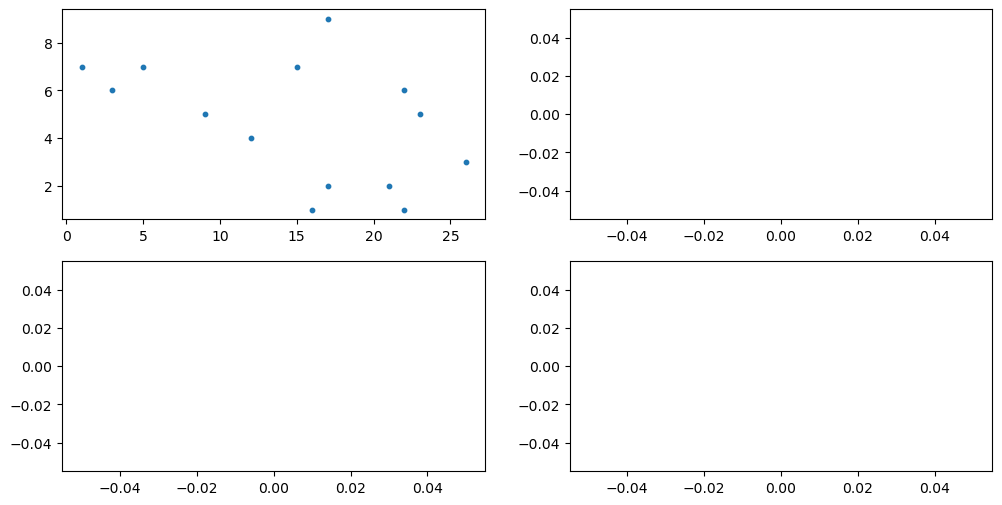

In [260]:

if disp_figs:
    %matplotlib inline
    fig,ax = plt.subplot_mosaic('AB;CD',figsize=(12,6))
    [ax[k].scatter(K_sparse[1][K_sparse[2]==i], K_sparse[0][K_sparse[2]==i],c=colors[i],s=10) for i,k in enumerate(['A','B','C','D'])]

# Generate the PG occurrences


In [261]:
# I suppose I can also do this in sparse and dense
# dense B: the binary image of the occurrences of the spiking motif as a ( M x T) matrix
# spare B: set of all times t and pg's b
B_dense = np.random.randint(0,999,(M,T))
B_dense[B_dense < pg_fr] = 1
B_dense[B_dense >= pg_fr] = 0
B_sparse = np.where(B_dense)

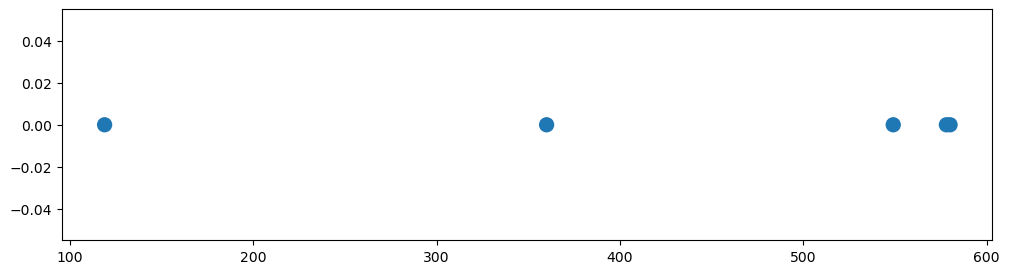

In [262]:
plt.figure(figsize=(12,3))
plt.scatter(B_sparse[1],B_sparse[0],c=colors[B_sparse[0]],s=100)
plt.show()

# Convolve the PG kernels with the PG firing times

In [263]:
# now to make the full raster plot keeping the labels in-tact
# dense A: the layered binary images of all neuron spikes by PG ( N x T x M
A_dense = np.zeros((N,T+D,M+1))
A_dense[...,-1] = np.random.randint(0,999,(N,T+D))
A_dense[...,-1] = (A_dense[...,-1] < background_noise_fr).astype('int')
for i in range(len(B_sparse[0])):
    t = B_sparse[1][i]
    b = B_sparse[0][i]
    A_dense[:, t:t+D, b] += K_dense[...,b]
    
A_dense.shape
# A_dense = A_dense[:,:1000,:]
A_sparse = np.where(A_dense)
A_dense = np.sum(A_dense,axis=2)
A_dense[A_dense>1] = 1
A_dense.shape

(10, 1031)

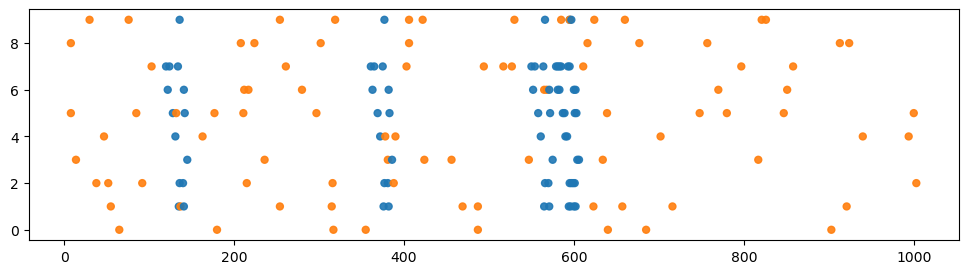

In [264]:
%matplotlib inline
plt.figure(figsize=(12,3))
plt.scatter(A_sparse[1],A_sparse[0],c=colors[A_sparse[2]],alpha=0.9,s=100,marker='.')
plt.show()

# Sanity Check

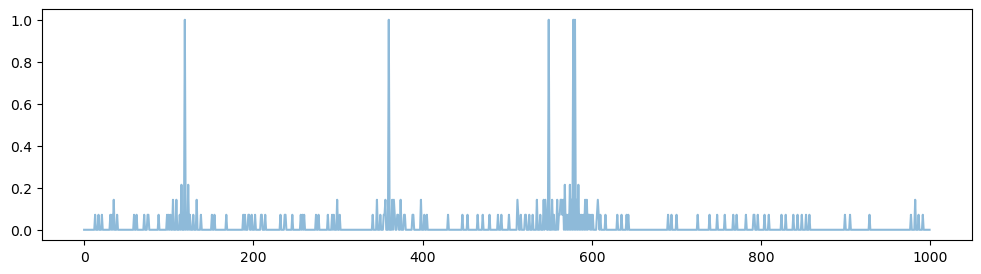

In [265]:
test = np.zeros((T,M))
%matplotlib inline
for j in range(M):
    for i in range(T):
        test[i,j] = np.sum(K_dense[...,j]*A_dense[:,i:i+D])
    test[:,j] = test[:,j]/np.max(test[:,j])
plt.figure(figsize=(12,3))
i = 0
plt.plot(test[:,i],color=colors[i],alpha=0.5)

# Windowing the data

In [266]:
test_row = 0

In [267]:
window_dim = (int(np.ceil(D/2)), N)
valid_spikes = (A_sparse[1] > window_dim[0]) & (A_sparse[1] < T- window_dim[0])

In [268]:
M_labels = A_sparse[2][valid_spikes]
N_labels = A_sparse[0][valid_spikes]
T_labels = A_sparse[1][valid_spikes]
windows = np.zeros((len(T_labels), N, window_dim[0]*2))
for i,window_time in enumerate(T_labels):
    windows[i,...] = A_dense[:,-window_dim[0]+window_time:window_dim[0]+window_time]
#     windows[i,N_labels[i],window_dim[0]] = 2
print('spikes: %d, neurons: %s, depth: %a' %windows.shape)

spikes: 154, neurons: 10, depth: 32


In [269]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [270]:
HDPs = []
sim_mats = []
# Set the cutoff value for clustering
cutoff = 1

# Get the cluster assignments for each spike based on the hierarchical clustering
clusters = []
for n in range(N):
    test = windows[N_labels==n]
    x = np.zeros((len(test),len(test)))
    for i in range(test.shape[0]):
        for j in range(test.shape[0]):
            x[i,j] = np.sum(test[i]*test[j])/ min(np.sum(test[i]),np.sum(test[j]))
    sim_mats.append(x)
    dissimilarity = 1 - x
    HDPs.append(linkage(dissimilarity, method='complete'))
    clusters += list((n*10)+fcluster(linkage(dissimilarity, method='complete'), cutoff, criterion='distance'))

clusters= np.array(clusters)

C:\Users\miles\AppData\Local\Temp\ipykernel_10312\3563588383.py:16: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  HDPs.append(linkage(dissimilarity, method='complete'))
C:\Users\miles\AppData\Local\Temp\ipykernel_10312\3563588383.py:17: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters += list((n*10)+fcluster(linkage(dissimilarity, method='complete'), cutoff, criterion='distance'))


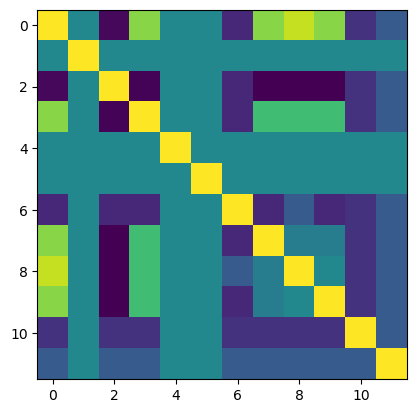

In [271]:
plt.figure()
plt.imshow(sim_mats[3])

In [272]:
clusters

array([ 1,  1,  3,  4,  1,  2,  1,  1, 18, 12, 19, 11, 15, 16, 12, 11, 14,
       15, 12, 11, 12, 13, 11, 11, 17, 14, 14, 15, 23, 27, 25, 21, 22, 24,
       26, 21, 22, 28, 21, 22, 21, 21, 22, 22, 31, 32, 35, 31, 32, 32, 34,
       31, 31, 31, 33, 32, 42, 41, 42, 41, 43, 44, 41, 41, 41, 42, 42, 56,
       52, 54, 51, 56, 55, 53, 52, 51, 52, 51, 52, 52, 51, 51, 57, 53, 53,
       56, 62, 61, 64, 65, 67, 62, 61, 62, 66, 65, 61, 62, 62, 61, 61, 63,
       63, 81, 79, 71, 77, 73, 79, 71, 77, 75, 73, 72, 78, 79, 71, 77, 79,
       80, 71, 71, 77, 77, 76, 82, 74, 85, 81, 86, 83, 82, 83, 83, 84, 83,
       91, 91, 96, 91, 91, 96, 95, 92, 94, 96, 93, 96, 96, 97, 94, 97, 91,
       91])

In [273]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

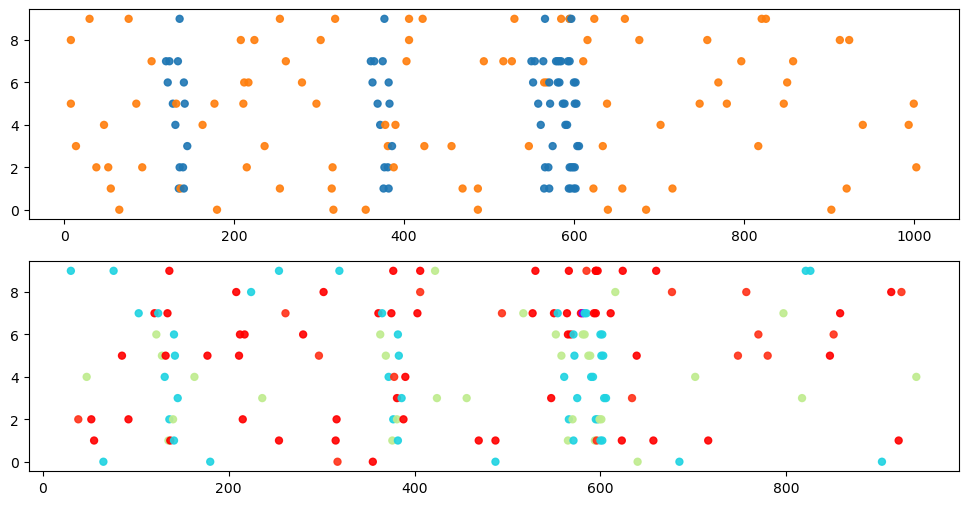

In [289]:
%matplotlib inline
fig,ax = plt.subplot_mosaic('A;B',figsize=(12,6))
ax['A'].scatter(A_sparse[1],A_sparse[0],c=colors[A_sparse[2]],alpha=0.9,s=100,marker='.')
ax['B'].scatter(A_sparse[1][valid_spikes],A_sparse[0][valid_spikes],c=cm.rainbow((clusters%10)/np.mean(clusters%10)),alpha=0.9,s=100,marker='.')
plt.show()

In [292]:
time_differences = []
cluster_sq = {}
for cluster in np.unique(clusters):
    time_differences.append(list(np.diff(A_sparse[1][valid_spikes][clusters == cluster])))
    if str(list(np.diff(A_sparse[1][valid_spikes][clusters == cluster]))) in cluster_sq.keys():
        cluster_sq[str(list(np.diff(A_sparse[1][valid_spikes][clusters == cluster])))] = cluster_sq[str(list(np.diff(A_sparse[1][valid_spikes][clusters == cluster])))] + [cluster]
    else: 
        cluster_sq[str(list(np.diff(A_sparse[1][valid_spikes][clusters == cluster])))] = [cluster]
        
new_labels = clusters.copy()
for l, key in enumerate(cluster_sq.keys()):
    for k in cluster_sq[key]:
        new_labels[new_labels == k] = l

import numpy as np
from scipy.optimize import linear_sum_assignment

# Given arrays
labels_array_1 = new_labels.copy()

labels_array_2 = A_sparse[2][valid_spikes].copy()

for l in np.unique(labels_array_1):
    if l not in labels_array_2:
        labels_array_2[labels_array_1 == l] = l

# Get unique labels from both arrays
unique_labels_1 = np.unique(labels_array_1)
unique_labels_2 = np.unique(labels_array_2)

# Create a cost matrix where each entry represents the cost of matching two labels
cost_matrix = np.zeros((len(unique_labels_1), len(unique_labels_2)))

for i, label_1 in enumerate(unique_labels_1):
    for j, label_2 in enumerate(unique_labels_2):
        common_elements = np.logical_and(labels_array_1 == label_1, labels_array_2 == label_2)
        cost_matrix[i, j] = -np.sum(common_elements)

# Use the Hungarian algorithm to find the optimal mapping
row_indices, col_indices = linear_sum_assignment(cost_matrix)

# Create a mapping dictionary from the optimal mapping
mapping_dict = {unique_labels_1[i]: unique_labels_2[j] for i, j in zip(row_indices, col_indices)}

# Map the labels from labels_array_1 to labels_array_2 using the mapping dictionary
mapped_labels = np.array([mapping_dict[label] for label in labels_array_1])

print(mapped_labels)
print(A_sparse[2])
print(new_labels)
scat_colors = mapped_labels.copy()
scat_colors[scat_colors >= M] = M
scat_colors

[ 0  0  1  1  0  1  0  0  1  3  1  2  5  1  3  2  4  5  3  2  3  1  2  2
  1  4  4  5  1  1  1  2  2  1  1  2  2  1  2  2  2  2  2  2  2  6  1  2
  6  6  1  2  2  2  1  6  7  2  7  2  1  1  2  2  2  7  7  9  2  1  2  9
  1  8  2  2  2  2  2  2  2  2  1  8  8  9  2  2  1 11  1  2  2  2  1 11
  2  2  2  2  2 10 10 13  3  2  2 12  3  2  2  1 12  1  1  3  2  2  3  1
  2  2  2  2  1 14  1  1 13  1 15 14 15 15  1 15 16 16 18 16 16 18  1  1
 17 18  1 18 18 19 17 19 16 16]
[1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 1 1 0 0
 1 0 0 0 0 0 0 1 1 0 1 1 0 1 1 1 0 0 0 1 1 1 0 1 0 1 1 0 0 0 1 1 1 1 1 0 1
 0 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 1 1 1 0 0 0 1 1 0 0 0 0 0 1 1 1 0 0
 0 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0
 1 1 1 0 1 0 1 0 1 1 1 1]
[ 0  0  1  1  0  1  0  0  1  3  1  2  5  1  3  2  4  5  3  2  3  1  2  2
  1  4  4  5  1  1  1  2  2  1  1  2  2  1  2  2  2  2  2  2  2  6  1  2
  6  6  1  2  2  2  1  6  7  2  7  2  1  1  2  2  2  7  7 

array([0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int64)

In [276]:
mapping_dict

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 11: 11,
 12: 12,
 13: 13,
 14: 14,
 15: 15,
 16: 16,
 17: 17,
 18: 18,
 19: 19}

In [277]:
unique_labels_1, unique_labels_2

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19], dtype=int64))

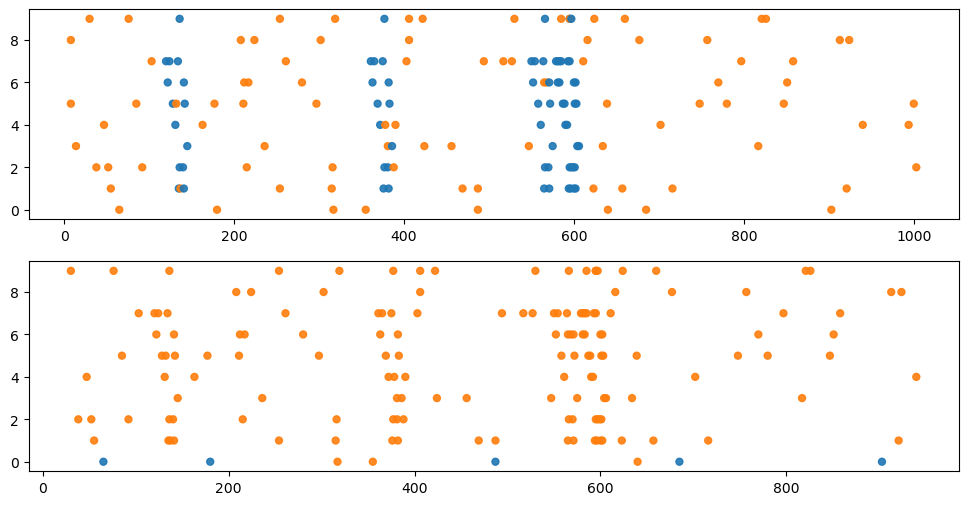

In [278]:
%matplotlib inline
fig,ax = plt.subplot_mosaic('A;B',figsize=(12,6))
ax['A'].scatter(A_sparse[1],A_sparse[0],c=colors[A_sparse[2]],alpha=0.9,s=100,marker='.')
ax['B'].scatter(A_sparse[1][valid_spikes],A_sparse[0][valid_spikes],c=colors[scat_colors],alpha=0.9,s=100,marker='.')
plt.show()

In [189]:
TP = 0
TN = 0
total_TP = 0
total_TN = 0
for m in range(M):
    TP += np.sum(((A_sparse[2][valid_spikes]==m) & (mapped_labels==m)) == True)
    TN += np.sum(((A_sparse[2][valid_spikes]!=m) & (mapped_labels!=m)) == True)
    total_TP += np.sum(A_sparse[2][valid_spikes]==m)
    total_TN += np.sum(A_sparse[2][valid_spikes]!=m)
    
TP/total_TP, TN/total_TN, total_TP,total_TN

(0.5555555555555556, 1.0, 18, 85)

In [182]:
np.sum(((A_sparse[2][valid_spikes]==m) & (mapped_labels==m)) == True)

10

In [172]:
mapped_labels==m

array([False,  True,  True, False, False, False,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False,  True, False, False,
       False, False, False, False])

In [157]:
A_sparse[2][A_sparse[2]==m]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [154]:
accuracy = np.sum(A_sparse[2]==mapped_labels)/len(A_sparse[2])
accuracy

C:\Users\miles\AppData\Local\Temp\ipykernel_10312\3825156868.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  accuracy = np.sum(A_sparse[2]==mapped_labels)/len(A_sparse[2])


0.0